In [24]:
%matplotlib widget

In [25]:
from ephysvibe.structures.neuron_data import NeuronData
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import os
import glob
from ephysvibe.trials import align_trials
from ephysvibe.trials.spikes import firing_rate
import platform
from joblib import Parallel, delayed
from tqdm import tqdm
import h5py
from pathlib import Path
from typing import Dict,List
import pca_tools
from scipy import stats
seed=2024

### Define functions

In [26]:
def to_python_hdf5(dat:List, save_path: Path):
    """Save data in hdf5 format."""
    # save the data
    with h5py.File(save_path, "w") as f:
        for i_d in range(len(dat)):
            group = f.create_group(str(i_d))

            for key, value in zip(dat[i_d].keys(), dat[i_d].values()):
                group.create_dataset(key, np.array(value).shape, data=value)
    f.close()

In [27]:
def from_python_hdf5(load_path: Path):
    """Load data from a file in hdf5 format from Python."""
    with h5py.File(load_path, "r") as f:
        data = []
        for i_g in f.keys():
            group = f[i_g]
            dataset={}
            for key, value in zip(group.keys(), group.values()):
                dataset[key] = np.array(value)
            data.append(dataset)
    f.close()
    return data

In [28]:
def z_score(x):
    mu = np.mean(x,axis=0)
    sigma = np.std(x,axis=0)
    sigma0=sigma
    sigma0[sigma == 0] = 1 
    zs_x = (x-mu) / sigma0
    return zs_x

In [29]:
def get_fr_samples(sp,sample_id,start,end,samples):
    # parameters
    n_trials = 10
    win=50
    # Check fr
    ms_fr=np.nanmean(sp[:,start:end])*1000>5
    if not ms_fr:
        return None
    # Average spikes
    avg_sample = firing_rate.moving_average(sp, win=win, step = 1)
    fr_samples = []
    for s_id in samples:
        sample_fr = avg_sample[np.where(sample_id==s_id,True,False),start:end]
        # Check number of trials
        if sample_fr.shape[0]< n_trials:
            return None
        fr_samples.append(np.mean(sample_fr,axis=0))
    return fr_samples


In [30]:
def get_neuron_sample_fr(path,time_before,start,end,rng):
    neu_data = NeuronData.from_python_hdf5(path)
    select_block=1
    code=1
    idx_start = time_before + start 
    idx_end = time_before+end
    # Select trials aligned to sample onset
    sp_sample_on,mask = align_trials.align_on(
        sp_samples=neu_data.sp_samples,
        code_samples=neu_data.code_samples,
        code_numbers=neu_data.code_numbers,
        trial_error=neu_data.trial_error,
        block=neu_data.block,
        pos_code=neu_data.pos_code,
        select_block= select_block,
        select_pos= code,
        event ="sample_on",
        time_before = time_before,
        error_type= 0,
    )
    if np.sum(mask)<20:
        return {'fr':None}
    sample_id = neu_data.sample_id[mask]
    fr_samples = get_fr_samples(sp_sample_on,sample_id,start=idx_start,end=idx_end,samples=[0,11,15,55,51])
    if fr_samples is None:
        return {'fr':None}
    return {'fr':fr_samples}

In [31]:
def check_triasl(sp,idx_start,idx_end):
    sig_trials = np.sum(sp,axis=1)>0
    return sig_trials

In [32]:
def get_neuron_sample_test1_fr(path,time_before,start,end,end_test,n_test,rng):
    neu_data = NeuronData.from_python_hdf5(path)
    select_block=1
    code=1
    idx_start = time_before + start 
    idx_end = time_before+end
    # Select trials aligned to sample onset
    sp_sample_on, mask_sample = align_trials.align_on(
        sp_samples=neu_data.sp_samples,
        code_samples=neu_data.code_samples,
        code_numbers=neu_data.code_numbers,
        trial_error=neu_data.trial_error,
        block=neu_data.block,
        pos_code=neu_data.pos_code,
        select_block= select_block,
        select_pos= code,
        event ="sample_on",
        time_before = time_before,
        error_type= 0,
    )
    sp_test1_on, mask_test1 = align_trials.align_on(
        sp_samples=neu_data.sp_samples,
        code_samples=neu_data.code_samples,
        code_numbers=neu_data.code_numbers,
        trial_error=neu_data.trial_error,
        block=neu_data.block,
        pos_code=neu_data.pos_code,
        select_block= select_block,
        select_pos= code,
        event ="test_on_1",
        time_before = 200,
        error_type= 0,
    )
    if np.any(mask_sample != mask_test1):
        print(path)
        return 
    mask_match=np.where(neu_data.test_stimuli[mask_test1,n_test-1]==neu_data.sample_id[mask_test1],True,False)
    mask_neu = neu_data.sample_id[mask_test1]==0
    max_test = neu_data.test_stimuli[mask_test1].shape[1]
    mask_ntest = (max_test-np.sum(np.isnan(neu_data.test_stimuli[mask_test1]),axis=1))>(n_test-1)
    #mask_match_neu = np.logical_or(mask_match,mask_neu)
    #mask_match_neu = np.logical_or(np.full(mask_neu.shape,True),mask_neu)
    mask_match_neu = np.logical_or(mask_ntest,mask_neu)
    if np.sum(mask_match_neu)<20:
        return {'fr':None}
    sp=np.concatenate((sp_sample_on[mask_match_neu,:time_before+450+200],sp_test1_on[mask_match_neu,:end_test+400]),axis=1)
    sample_id = neu_data.sample_id[mask_test1][mask_match_neu]
    fr_samples = get_fr_samples(sp,sample_id,start=idx_start,end=idx_end,samples=[0,11,15,55,51])
    if fr_samples is None:
        return {'fr':None}
    return {'fr':fr_samples}

### Read data

In [33]:
if platform.system() == 'Linux':
    basepath = '/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/new_structure/'
elif platform.system() == 'Windows':
    basepath = 'C:/Users/camil/Documents/int/'

In [34]:
area='lip'
neu_path = basepath+'/session_struct/'+area+'/neurons/*neu.h5'
path_list = glob.glob(neu_path)

In [35]:
# Load data
n_test=4
time_before=500
start=-200
end_test = n_test*450+200
end=450+200+200+end_test

idx_start = time_before + start 
idx_end = time_before+end

In [36]:
end-start

3050

In [37]:
rng = np.random.default_rng(seed=seed)
data = Parallel(n_jobs = -1)(delayed(get_neuron_sample_test1_fr)(path,time_before,start,end,end_test,n_test,rng) for path in tqdm(path_list))

100%|██████████| 530/530 [11:49<00:00,  1.34s/it]


In [38]:
neurons_fr = []
for asc in data:
    fr = asc["fr"]
    if fr is not None:
        neurons_fr.append(asc)
to_python_hdf5(dat=neurons_fr, save_path='/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/pca/data/'+area+'_win50_test'+str(n_test)+'_nmatch_10tr_pca.h5')

In [39]:
neurons_fr_read=from_python_hdf5(load_path='/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/pca/data/'+area+'_win50_test'+str(n_test)+'_nmatch_10tr_pca.h5')
neurons_fr = []
for asc in neurons_fr_read:
    fr = asc["fr"]
    if fr is not None:
        fr_concat = np.concatenate(fr,axis=0)
        neurons_fr.append(fr_concat)

In [40]:
neurons_fr = np.array(neurons_fr)#.reshape(-1,1050)
neurons_fr.shape

(128, 15250)

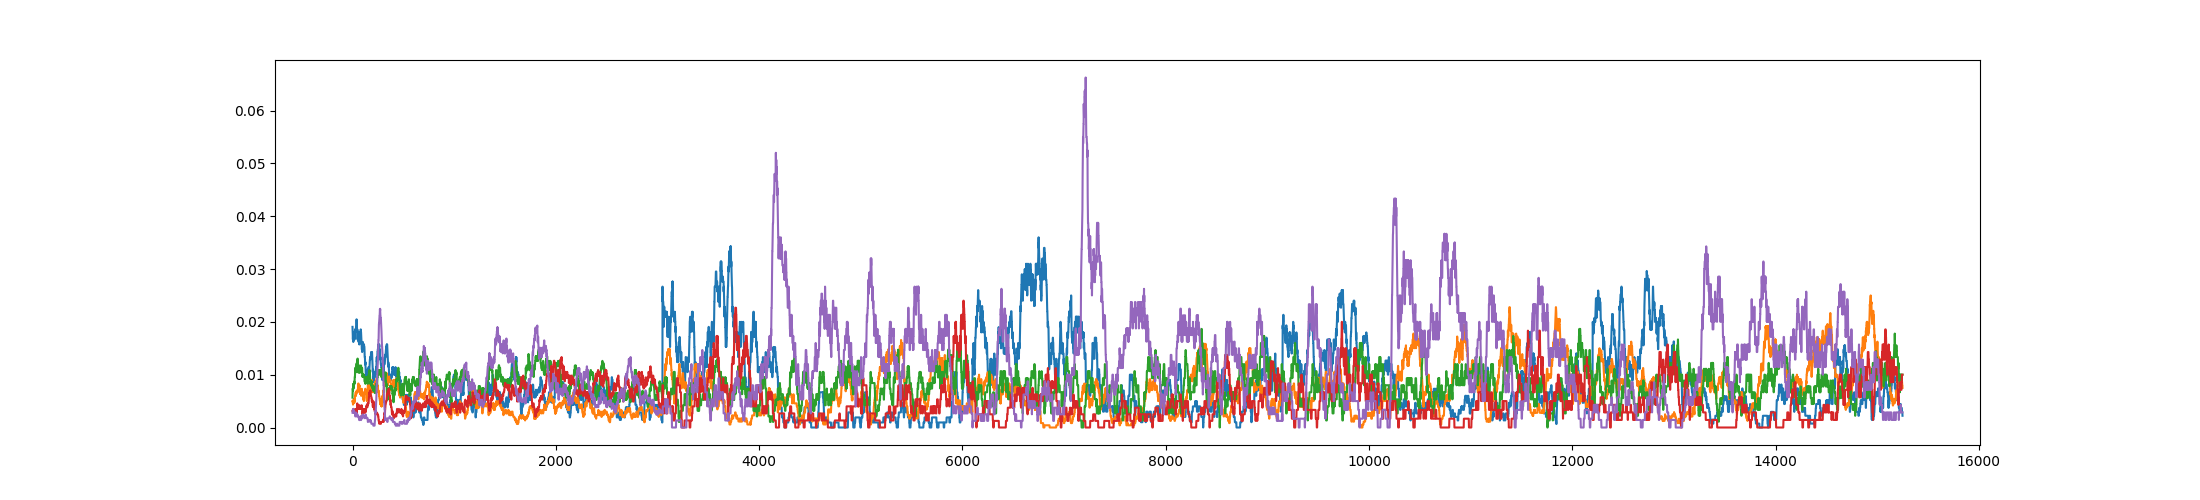

In [41]:
plt.subplots(figsize=(22,5))
_=plt.plot(neurons_fr[0:5].T)

lip: 9 components to explain 80% of the variance


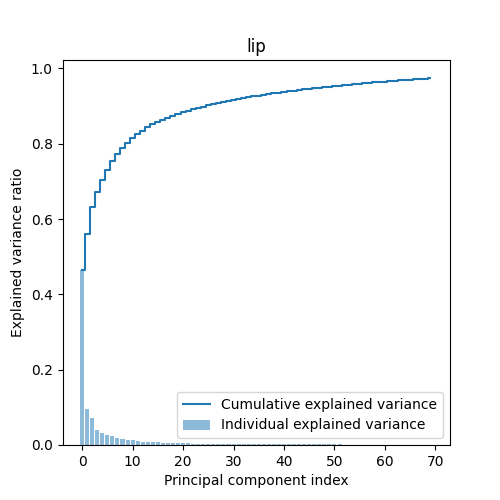

In [42]:
n_comp=70
model,pc_s = pca_tools.compute_pca(neurons_fr,n_comp=n_comp)
pca_tools.plot_explained_var(model,figsize=(5,5),area=area)

In [43]:

# Define epochs
test1_st =200+450+400
test2_st = test1_st+450
test3_st = test2_st+450
test4_st = test3_st+450
test5_st = test4_st+450
idx_f = np.arange(0,200,2)
idx_s = np.arange(200,200+450,2)
idx_d = np.arange(200+450,test1_st,2)
idx_t1 = np.arange(test1_st,test2_st,2)
idx_t2 = np.arange(test2_st,test3_st,2)
idx_t3 = np.arange(test3_st,test4_st,2)
idx_t4 = np.arange(test4_st,test5_st,2)
idx_aftert = np.arange(test5_st,end-start,2)

In [44]:
pc_s.shape

(70, 15250)

In [45]:
def plot_pc_3d(pcomp, colors, t_epochs, area, figsize=(5, 5)):
    i = 0
    fig, ax = plt.subplots(
        figsize=figsize, sharey=True, sharex=True, subplot_kw={"projection": "3d"}
    )
    for key in t_epochs.keys():
        ax.plot(
            pcomp[i][t_epochs[key]],
            pcomp[i + 1][t_epochs[key]],
            pcomp[i + 2][t_epochs[key]],
            color=colors[key],
            label=key,
            markersize=0.5
        )
        ax.scatter(
            pcomp[i][t_epochs[key]][0],
            pcomp[i + 1][t_epochs[key]][0],
            pcomp[i + 2][t_epochs[key]][0],
            color=colors[key],
            s=30
        )
        ax.scatter(
            pcomp[i][t_epochs[key]],
            pcomp[i + 1][t_epochs[key]],
            pcomp[i + 2][t_epochs[key]],
            color=colors[key],
            s=5
        )

    fig.suptitle(area)
    ax.set(xlabel="PC " + str(i), ylabel="PC " + str(i + 1), zlabel="PC " + str(i + 2))
    ax.legend(
        fontsize=9, columnspacing=0.5, facecolor="white", framealpha=1, loc="best"
    )
    fig.tight_layout(pad=0.2, h_pad=0.2, w_pad=0.8)

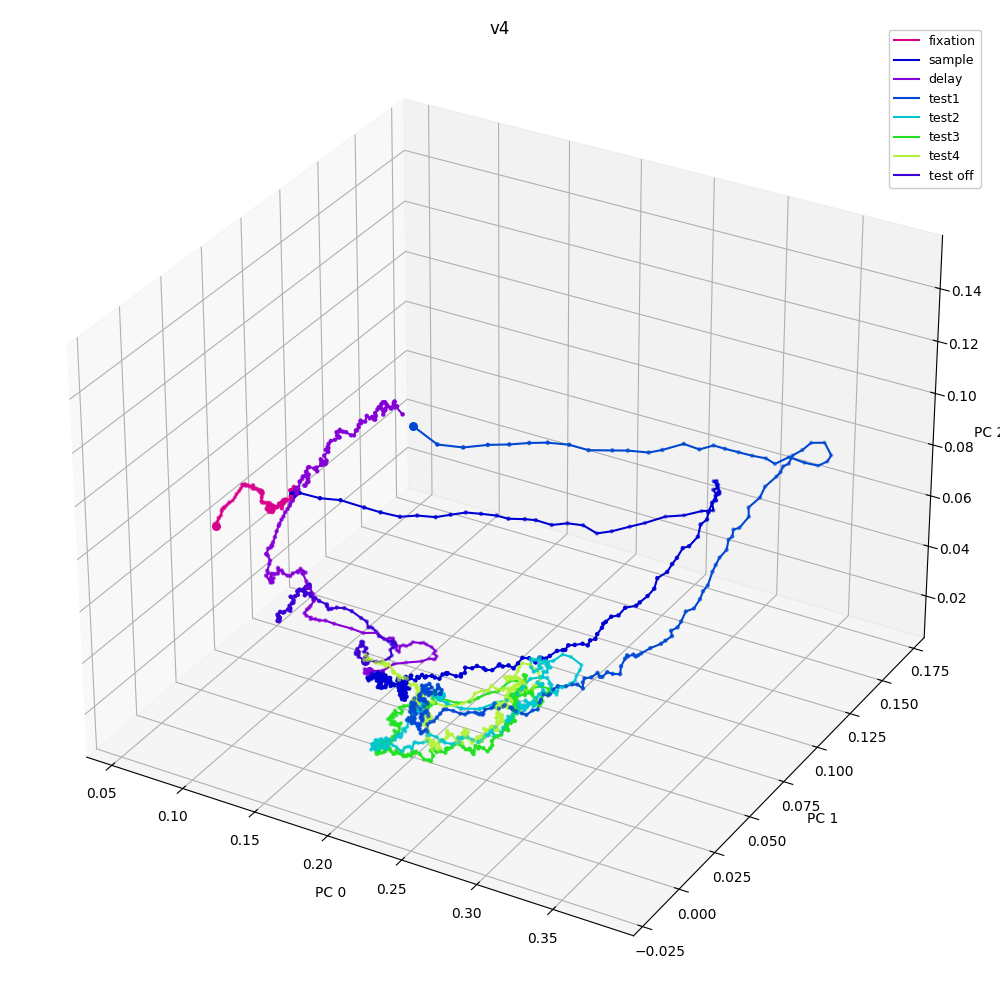

In [46]:
colors_g=['#D9008E','#0000D2','#8400D6',
          '#0048D1',
          '#00C6CF',
          '#21E121',
          '#B5F23C','#3900D4']
t_epochs = {'fixation':idx_f,'sample':idx_s,'delay':idx_d,'test1':idx_t1,'test2':idx_t2,'test3':idx_t3,'test4':idx_t4,'test off':idx_aftert}#
colors = {'fixation':colors_g[0],'sample':colors_g[1],'delay':colors_g[2],'test1':colors_g[3],'test2':colors_g[4],'test3':colors_g[5],'test4':colors_g[6],'test off':colors_g[-1]}#

reshape_pc_s = pc_s.reshape(n_comp,-1,end-start)
mean_pc_s= np.mean(reshape_pc_s[:,1:,:],axis=1)
plot_pc_3d(mean_pc_s,colors,t_epochs,'v4',figsize=(10,10))